# Load the data

In [1]:
#Loading is of 10 logo types. 
#It's after preprocessing to organise the images under folders with their class names.

import numpy as np
from tensorflow import keras

#Define the data folder
data_dir='C:/Research/Logo detection project/flicker_logos_27_dataset/labeled_images_10'

#Set the image size (known from the dataset)
input_shape=[500,375,3]


#Load the images their labels and split to train/test
train_data , test_data=keras.utils.image_dataset_from_directory(
    data_dir,labels='inferred',label_mode='categorical',class_names=None,
    color_mode='rgb',batch_size=32,image_size=input_shape[:2],shuffle=True,seed=0,
    validation_split=0.2, subset='both',interpolation='bilinear',follow_links=False,
    crop_to_aspect_ratio=False)


#Get the class names (will be used for plots)
class_names=test_data.class_names

#Get the number of classes
num_classes=len(test_data.class_names)

#Get the size of test set
test_size=len(test_data.file_paths)



Found 300 files belonging to 10 classes.
Using 240 files for training.
Using 60 files for validation.


# Augmentation of data

In [2]:
#Here augmentation (horizontal and vertical flip, rotation and zoom) is defined and will be used within the model.

from keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.1),
        layers.RandomRotation(0.2),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.1),
        layers.RandomZoom(0.2),
        layers.RandomZoom(0.3)
    ]
)

# Create the model

In [3]:
import tensorflow as tf

#Load the pre-trained model (InceptionV3)
base_model=tf.keras.applications.InceptionV3(weights='imagenet', input_shape=input_shape, include_top=False) 

#Unfrezze the base model
base_model.trainable = True

#Define the shape of inputs
inputs = keras.Input(shape=input_shape)

#Add the augmantaion layers
x = data_augmentation(inputs)

#Preprocessing layer to rescale pixel values to be between -1 and 1 
scale_layer=keras.layers.Lambda(keras.applications.inception_v3.preprocess_input)
x = scale_layer(x)

#When unfrezzing the base model, batch normalization layers must retain their weight values by: training=False
x=base_model(x,training=False)

#Define the pooling method
x = keras.layers.GlobalAveragePooling2D()(x) 

#Add Dropout layer to reduce overfitting
x=keras.layers.Dropout(0.2)(x)

#Add the new output (classification) layer
outputs=keras.layers.Dense(num_classes, activation='softmax')(x)

#Create the model (combine the pretrained and the new layer)
model = keras.Model(inputs, outputs)

model.summary()

#Define the learning rate and optimizer
lr=1e-5
optim=keras.optimizers.Adam(lr)

#Compile the model
model.compile(loss='categorical_crossentropy',optimizer=optim, metrics='accuracy')



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 375, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 500, 375, 3)       0         
                                                                 
 lambda (Lambda)             (None, 500, 375, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 14, 10, 2048)      21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

# Training the model

In [4]:
#Next line to train the model (muted since training was already done and the results were saved)
#history=model.fit(train_data,epochs=10,validation_data=test_data)



#Load saved model
import pickle
saved_model=tf.keras.models.load_model('C:/Research/Logo detection project/models/model4')
with open('C:/Research/Logo detection project/models/model4/trainHistoryDict', "rb") as file_pi:
    saved_history = pickle.load(file_pi)




# Plot accuracy from train and test data

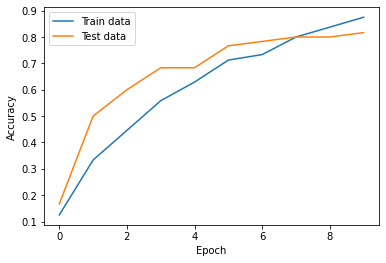

Accuracy train: 0.875
Accuracy validiation: 0.8166666626930237


In [5]:
import matplotlib.pyplot as plt

#Plot using the "saved_history" from the saved results of training 

plt.plot(saved_history['accuracy'], label='Train data')
plt.plot(saved_history['val_accuracy'], label='Test data')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Print Accuracy values at the end of training
print(f"Accuracy train: {saved_history['accuracy'][-1]}")
print(f"Accuracy validation: {saved_history['val_accuracy'][-1]}")

# Evaluate the model (from a confusion matrix)

2/2 [==============================] - 5s 2s/step


Text(33.0, 0.5, 'real')

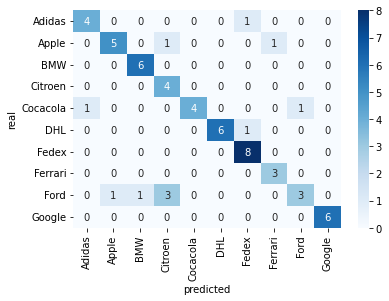

In [12]:
#Get the model predictions (each prediction is a 10-element array, where the highest score element is the predicted class)
y_pred_scores=saved_model.predict(test_data)

#Make classes as numbers between 0-9
y_pred=np.argmax(y_pred_scores,axis=1) 


##Get the true classes
#make "test_data" (a tf.data.Dataset object) subscriptable
np_test_data=list(test_data.as_numpy_iterator())

y_true_array=np.array([]) 

#Iterate on the batches of the test data and get the classes
for x in np_test_data:
    y_true_array=np.append(y_true_array,x[1])

#Reshape according to test size and num of classes
y_true_array=np.reshape(y_true_array,(test_size,num_classes))

#Make classes as numbers between 0-9
y_true=np.argmax(y_true_array,axis=1)



#Create the confusion matrix using tf
con_mat=tf.math.confusion_matrix(y_true, y_pred) 

#Visulize it using Seaborn
import seaborn as sns

fig = plt.figure()
sns.heatmap(con_mat, annot=True, cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('predicted')
plt.ylabel('real')
